In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

# Define features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])  # Features
y = df['age']  # Target: age

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=949
)

In [3]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=500,
    eta = 0.1,
    gamma = 0,
    max_depth=10,
    random_state=949
)

In [5]:
## hypertuning

param_grid = {
    'n_estimators': [500],              
    'max_depth': [5],
    'eta': [0.025, 0.05]          
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator= xgb_model,
    param_grid=param_grid,
    cv=10,
    scoring= 'neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)
#print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'eta': 0.05, 'max_depth': 5, 'n_estimators': 500}


In [3]:
# retrain model

xgb_model = XGBRegressor(
    n_estimators=500,
    eta = 0.05,
    gamma = 0,
    max_depth=5,
    random_state=949
)

xgb_model.fit(X_train, y_train)

# Predict
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [11]:
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)

=== Training Set ===
RMSE: 0.4072

=== Test Set ===
RMSE: 1.3678
RMSE per phase (Train):
phase
G0    0.351074
G1    0.357243
G2    0.460067
M     0.379744
S     0.471797
dtype: float64

RMSE per phase (Test):
phase
G0    1.490318
G1    1.151884
G2    1.385290
M     3.437150
S     1.443724
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_74152/3800106582.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_74152/3800106582.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(


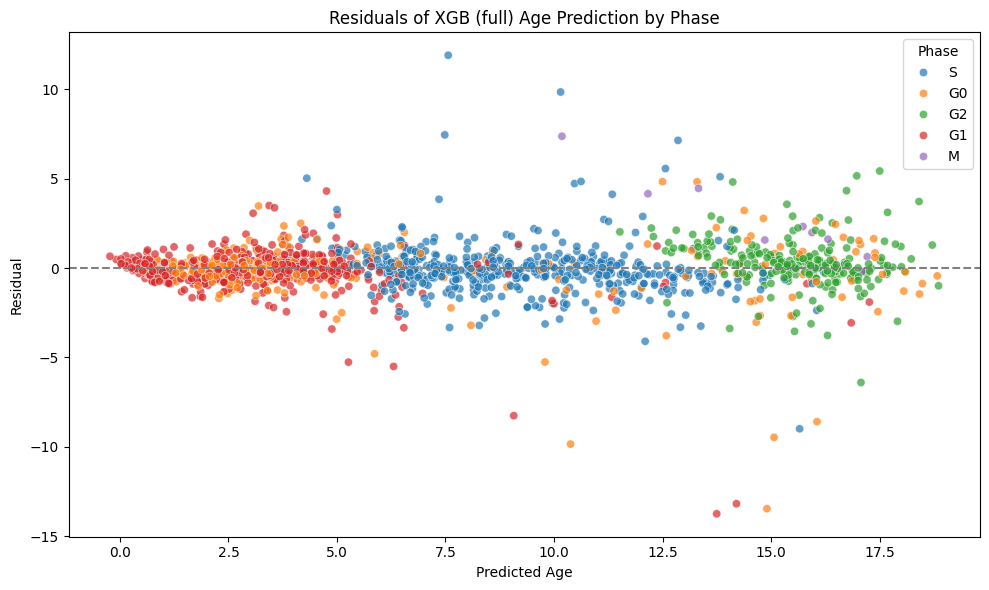

In [12]:
## PLOT RESIDUALS
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'True Age': y_test,
    'Predicted Age': y_test_pred,
    'Residual': y_test - y_test_pred,
    'Phase': df.loc[y_test.index, 'phase']
})

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Predicted Age',
    y='Residual',
    hue='Phase',
    palette='tab10',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of XGB (full) Age Prediction by Phase")
plt.xlabel("Predicted Age")
plt.ylabel("Residual")
plt.legend(title='Phase')
plt.tight_layout()

# Save the plot
plot_path = "xgb_regression_full.png"
plt.savefig(plot_path, dpi=300)
plt.show()

                    MDI Importance
Feature                           
E2F1..nuc.median.            689.0
cycA..nuc.median.            466.0
cycD1..nuc.median.           344.0
Nuc.area                     321.0
Int_Intg_DNA_nuc             304.0
...                            ...
pp53..cell.median.             7.0
pp27..cell.median.             6.0
DNA..cell.median.              5.0
pp21..cell.median.             5.0
cJun..cell.median.             4.0

[209 rows x 1 columns]


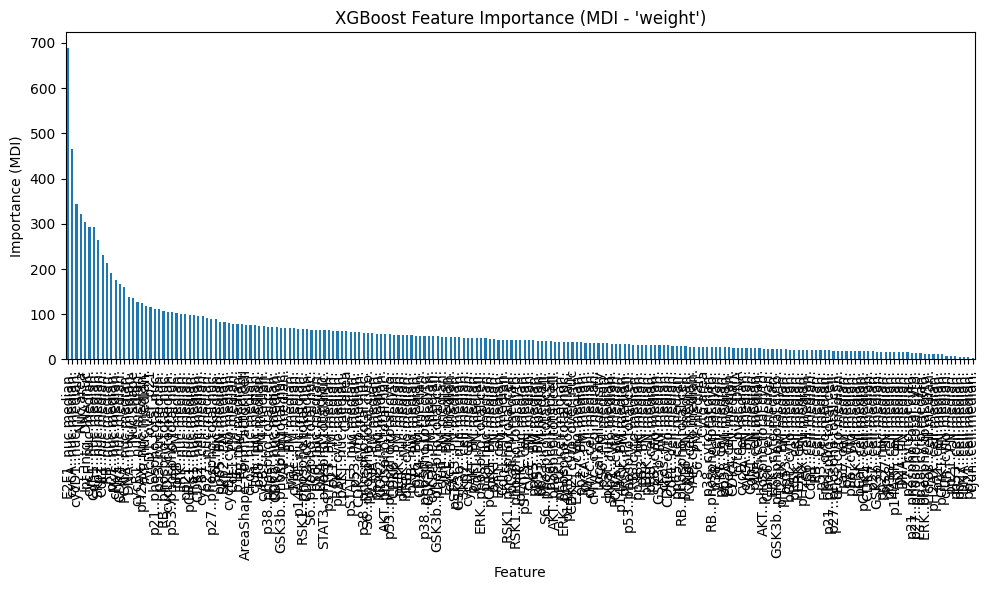

In [ ]:
# MDI feature ranking (weight)
booster = xgb_model.get_booster()

# Get importance by "weight" (~ MDI)
importance_dict = booster.get_score(importance_type='weight')

# Convert to DataFrame
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['MDI Importance'])
importance_df.index.name = 'Feature'
importance_df = importance_df.sort_values(by='MDI Importance', ascending=False)

# Display
print(importance_df)

# Optional: Plot
importance_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title("XGBoost Feature Importance (MDI - 'weight')")
plt.ylabel("Importance (MDI)")
plt.tight_layout()
plt.show()